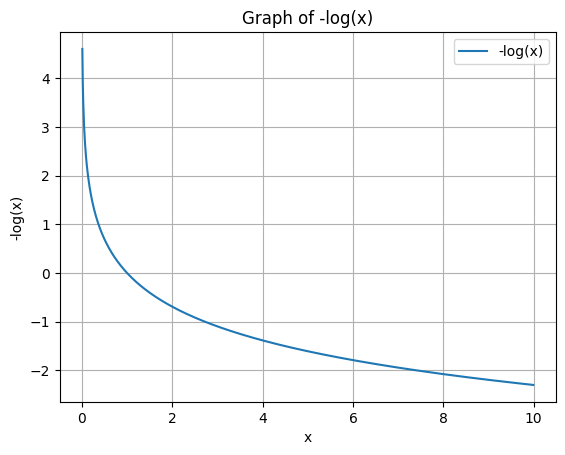

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 x 的范围，从 0.01 到 10，间隔为 0.01
x = np.arange(0.01, 10, 0.01)
# 计算 -log(x)
y = -np.log(x)

# 绘制图像
plt.plot(x, y, label='-log(x)')
plt.xlabel('x')
plt.ylabel('-log(x)')
plt.title('Graph of -log(x)')
plt.legend()
plt.grid(True)
plt.show()


# softmax回归
:label:`sec_softmax`

在 :numref:`sec_linear_regression`中我们介绍了线性回归。
随后，在 :numref:`sec_linear_scratch`中我们从头实现线性回归。
然后，在 :numref:`sec_linear_concise`中我们使用深度学习框架的高级API简洁实现线性回归。

回归可以用于预测*多少*的问题。
比如预测房屋被售出价格，或者棒球队可能获得的胜场数，又或者患者住院的天数。

事实上，我们也对*分类*问题感兴趣：不是问“多少”，而是问“哪一个”：

* 某个电子邮件是否属于垃圾邮件文件夹？
* 某个用户可能*注册*或*不注册*订阅服务？
* 某个图像描绘的是驴、狗、猫、还是鸡？
* 某人接下来最有可能看哪部电影？

通常，机器学习实践者用*分类*这个词来描述两个有微妙差别的问题：
1. 我们只对样本的“硬性”类别感兴趣，即属于哪个类别；
2. 我们希望得到“软性”类别，即得到属于每个类别的概率。
这两者的界限往往很模糊。其中的一个原因是：即使我们只关心硬类别，我们仍然使用软类别的模型。

## 分类问题
:label:`subsec_classification-problem`

我们从一个图像分类问题开始。
假设每次输入是一个$2\times2$的灰度图像。
我们可以用一个标量表示每个像素值，每个图像对应四个特征$x_1, x_2, x_3, x_4$。
此外，假设每个图像属于类别“猫”“鸡”和“狗”中的一个。

接下来，我们要选择如何表示标签。
我们有两个明显的选择：最直接的想法是选择$y \in \{1, 2, 3\}$，
其中整数分别代表$\{\text{狗}, \text{猫}, \text{鸡}\}$。
这是在计算机上存储此类信息的有效方法。
如果类别间有一些自然顺序，
比如说我们试图预测$\{\text{婴儿}, \text{儿童}, \text{青少年}, \text{青年人}, \text{中年人}, \text{老年人}\}$，
那么将这个问题转变为回归问题，并且保留这种格式是有意义的。

但是一般的分类问题并不与类别之间的自然顺序有关。
幸运的是，统计学家很早以前就发明了一种表示分类数据的简单方法：*独热编码*（one-hot encoding）。
独热编码是一个向量，它的分量和类别一样多。
类别对应的分量设置为1，其他所有分量设置为0。
在我们的例子中，标签$y$将是一个三维向量，
其中$(1, 0, 0)$对应于“猫”、$(0, 1, 0)$对应于“鸡”、$(0, 0, 1)$对应于“狗”：

$$y \in \{(1, 0, 0), (0, 1, 0), (0, 0, 1)\}.$$

## 网络架构

为了估计所有可能类别的条件概率，我们需要一个有多个输出的模型，每个类别对应一个输出。
为了解决线性模型的分类问题，我们需要和输出一样多的*仿射函数*（affine function）。
每个输出对应于它自己的仿射函数。
在我们的例子中，由于我们有4个特征和3个可能的输出类别，
我们将需要12个标量来表示权重（带下标的$w$），
3个标量来表示偏置（带下标的$b$）。
下面我们为每个输入计算三个*未规范化的预测*（logit）：$o_1$、$o_2$和$o_3$。

$$
\begin{aligned}
o_1 &= x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,\\
o_2 &= x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2,\\
o_3 &= x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
\end{aligned}
$$

我们可以用神经网络图 :numref:`fig_softmaxreg`来描述这个计算过程。
与线性回归一样，softmax回归也是一个单层神经网络。
由于计算每个输出$o_1$、$o_2$和$o_3$取决于
所有输入$x_1$、$x_2$、$x_3$和$x_4$，
所以softmax回归的输出层也是全连接层。

![softmax回归是一种单层神经网络](../img/softmaxreg.svg)
:label:`fig_softmaxreg`

为了更简洁地表达模型，我们仍然使用线性代数符号。
通过向量形式表达为$\mathbf{o} = \mathbf{W} \mathbf{x} + \mathbf{b}$，
这是一种更适合数学和编写代码的形式。
由此，我们已经将所有权重放到一个$3 \times 4$矩阵中。
对于给定数据样本的特征$\mathbf{x}$，
我们的输出是由权重与输入特征进行矩阵-向量乘法再加上偏置$\mathbf{b}$得到的。

## 全连接层的参数开销
:label:`subsec_parameterization-cost-fc-layers`

正如我们将在后续章节中看到的，在深度学习中，全连接层无处不在。
然而，顾名思义，全连接层是“完全”连接的，可能有很多可学习的参数。
具体来说，对于任何具有$d$个输入和$q$个输出的全连接层，
参数开销为$\mathcal{O}(dq)$，这个数字在实践中可能高得令人望而却步。
幸运的是，将$d$个输入转换为$q$个输出的成本可以减少到$\mathcal{O}(\frac{dq}{n})$，
其中超参数$n$可以由我们灵活指定，以在实际应用中平衡参数节约和模型有效性
 :cite:`Zhang.Tay.Zhang.ea.2021`。

## softmax运算
:label:`subsec_softmax_operation`

现在我们将优化参数以最大化观测数据的概率。
为了得到预测结果，我们将设置一个阈值，如选择具有最大概率的标签。

我们希望模型的输出$\hat{y}_j$可以视为属于类$j$的概率，
然后选择具有最大输出值的类别$\operatorname*{argmax}_j y_j$作为我们的预测。
例如，如果$\hat{y}_1$、$\hat{y}_2$和$\hat{y}_3$分别为0.1、0.8和0.1，
那么我们预测的类别是2，在我们的例子中代表“鸡”。

然而我们能否将未规范化的预测$o$直接视作我们感兴趣的输出呢？
答案是否定的。
因为将线性层的输出直接视为概率时存在一些问题：
一方面，我们没有限制这些输出数字的总和为1。
另一方面，根据输入的不同，它们可以为负值。
这些违反了 :numref:`sec_prob`中所说的概率基本公理。

要将输出视为概率，我们必须保证在任何数据上的输出都是非负的且总和为1。
此外，我们需要一个训练的目标函数，来激励模型精准地估计概率。
例如，
在分类器输出0.5的所有样本中，我们希望这些样本是刚好有一半实际上属于预测的类别。
这个属性叫做*校准*（calibration）。

社会科学家邓肯·卢斯于1959年在*选择模型*（choice model）的理论基础上
发明的*softmax函数*正是这样做的：
softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持
可导的性质。
为了完成这一目标，我们首先对每个未规范化的预测求幂，这样可以确保输出非负。
为了确保最终输出的概率值总和为1，我们再让每个求幂后的结果除以它们的总和。如下式：

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{其中}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$$
:eqlabel:`eq_softmax_y_and_o`

这里，对于所有的$j$总有$0 \leq \hat{y}_j \leq 1$。
因此，$\hat{\mathbf{y}}$可以视为一个正确的概率分布。
softmax运算不会改变未规范化的预测$\mathbf{o}$之间的大小次序，只会确定分配给每个类别的概率。
因此，在预测过程中，我们仍然可以用下式来选择最有可能的类别。

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。
因此，softmax回归是一个*线性模型*（linear model）。

## 小批量样本的矢量化
:label:`subsec_softmax_vectorization`

为了提高计算效率并且充分利用GPU，我们通常会对小批量样本的数据执行矢量计算。
假设我们读取了一个批量的样本$\mathbf{X}$，
其中特征维度（输入数量）为$d$，批量大小为$n$。
此外，假设我们在输出中有$q$个类别。
那么小批量样本的特征为$\mathbf{X} \in \mathbb{R}^{n \times d}$，
权重为$\mathbf{W} \in \mathbb{R}^{d \times q}$，
偏置为$\mathbf{b} \in \mathbb{R}^{1\times q}$。
softmax回归的矢量计算表达式为：

$$ \begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned} $$
:eqlabel:`eq_minibatch_softmax_reg`

相对于一次处理一个样本，
小批量样本的矢量化加快了$\mathbf{X}和\mathbf{W}$的矩阵-向量乘法。
由于$\mathbf{X}$中的每一行代表一个数据样本，
那么softmax运算可以*按行*（rowwise）执行：
对于$\mathbf{O}$的每一行，我们先对所有项进行幂运算，然后通过求和对它们进行标准化。
在 :eqref:`eq_minibatch_softmax_reg`中，
$\mathbf{X} \mathbf{W} + \mathbf{b}$的求和会使用广播机制，
小批量的未规范化预测$\mathbf{O}$和输出概率$\hat{\mathbf{Y}}$
都是形状为$n \times q$的矩阵。

## 损失函数

接下来，我们需要一个损失函数来度量预测的效果。
我们将使用最大似然估计，这与在线性回归
（ :numref:`subsec_normal_distribution_and_squared_loss`）
中的方法相同。

### 对数似然

softmax函数给出了一个向量$\hat{\mathbf{y}}$，
我们可以将其视为“对给定任意输入$\mathbf{x}$的每个类的条件概率”。
例如，$\hat{y}_1$=$P(y=\text{猫} \mid \mathbf{x})$。
假设整个数据集$\{\mathbf{X}, \mathbf{Y}\}$具有$n$个样本，
其中索引$i$的样本由特征向量$\mathbf{x}^{(i)}$和独热标签向量$\mathbf{y}^{(i)}$组成。
我们可以将估计值与实际值进行比较：

$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).
$$

根据最大似然估计，我们最大化$P(\mathbf{Y} \mid \mathbf{X})$，相当于最小化负对数似然：

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),
$$

其中，对于任何标签$\mathbf{y}$和模型预测$\hat{\mathbf{y}}$，损失函数为：

$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j. $$
:eqlabel:`eq_l_cross_entropy`

在本节稍后的内容会讲到， :eqref:`eq_l_cross_entropy`中的损失函数
通常被称为*交叉熵损失*（cross-entropy loss）。
由于$\mathbf{y}$是一个长度为$q$的独热编码向量，
所以除了一个项以外的所有项$j$都消失了。
由于所有$\hat{y}_j$都是预测的概率，所以它们的对数永远不会大于$0$。
因此，如果正确地预测实际标签，即如果实际标签$P(\mathbf{y} \mid \mathbf{x})=1$，
则损失函数不能进一步最小化。
注意，这往往是不可能的。
例如，数据集中可能存在标签噪声（比如某些样本可能被误标），
或输入特征没有足够的信息来完美地对每一个样本分类。

### softmax及其导数
:label:`subsec_softmax_and_derivatives`

由于softmax和相关的损失函数很常见，
因此我们需要更好地理解它的计算方式。
将 :eqref:`eq_softmax_y_and_o`代入损失 :eqref:`eq_l_cross_entropy`中。
利用softmax的定义，我们得到：

$$
\begin{aligned}
l(\mathbf{y}, \hat{\mathbf{y}}) &=  - \sum_{j=1}^q y_j \log \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} \\
&= \sum_{j=1}^q y_j \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j\\
&= \log \sum_{k=1}^q \exp(o_k) - \sum_{j=1}^q y_j o_j.
\end{aligned}
$$

考虑相对于任何未规范化的预测$o_j$的导数，我们得到：

$$
\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.
$$

换句话说，导数是我们softmax模型分配的概率与实际发生的情况（由独热标签向量表示）之间的差异。
从这个意义上讲，这与我们在回归中看到的非常相似，
其中梯度是观测值$y$和估计值$\hat{y}$之间的差异。
这不是巧合，在任何指数族分布模型中
（参见[本书附录中关于数学分布的一节](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/distributions.html)），
对数似然的梯度正是由此得出的。
这使梯度计算在实践中变得容易很多。

### 交叉熵损失

现在让我们考虑整个结果分布的情况，即观察到的不仅仅是一个结果。
对于标签$\mathbf{y}$，我们可以使用与以前相同的表示形式。
唯一的区别是，我们现在用一个概率向量表示，如$(0.1, 0.2, 0.7)$，
而不是仅包含二元项的向量$(0, 0, 1)$。
我们使用 :eqref:`eq_l_cross_entropy`来定义损失$l$，
它是所有标签分布的预期损失值。
此损失称为*交叉熵损失*（cross-entropy loss），它是分类问题最常用的损失之一。
本节我们将通过介绍信息论基础来理解交叉熵损失。
如果想了解更多信息论的细节，请进一步参考
[本书附录中关于信息论的一节](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/information-theory.html)。

## 信息论基础
:label:`subsec_info_theory_basics`

*信息论*（information theory）涉及编码、解码、发送以及尽可能简洁地处理信息或数据。

### 熵

信息论的核心思想是量化数据中的信息内容。
在信息论中，该数值被称为分布$P$的*熵*（entropy）。可以通过以下方程得到：

$$H[P] = \sum_j - P(j) \log P(j).$$
:eqlabel:`eq_softmax_reg_entropy`

信息论的基本定理之一指出，为了对从分布$p$中随机抽取的数据进行编码，
我们至少需要$H[P]$“纳特（nat）”对其进行编码。
“纳特”相当于*比特*（bit），但是对数底为$e$而不是2。因此，一个纳特是$\frac{1}{\log(2)} \approx 1.44$比特。

### 信息量

压缩与预测有什么关系呢？
想象一下，我们有一个要压缩的数据流。
如果我们很容易预测下一个数据，那么这个数据就很容易压缩。
为什么呢？
举一个极端的例子，假如数据流中的每个数据完全相同，这会是一个非常无聊的数据流。
由于它们总是相同的，我们总是知道下一个数据是什么。
所以，为了传递数据流的内容，我们不必传输任何信息。也就是说，“下一个数据是xx”这个事件毫无信息量。

但是，如果我们不能完全预测每一个事件，那么我们有时可能会感到"惊异"。
克劳德·香农决定用信息量$\log \frac{1}{P(j)} = -\log P(j)$来量化这种惊异程度。
在观察一个事件$j$时，并赋予它（主观）概率$P(j)$。
当我们赋予一个事件较低的概率时，我们的惊异会更大，该事件的信息量也就更大。
在 :eqref:`eq_softmax_reg_entropy`中定义的熵，
是当分配的概率真正匹配数据生成过程时的*信息量的期望*。

### 重新审视交叉熵

如果把熵$H(P)$想象为“知道真实概率的人所经历的惊异程度”，那么什么是交叉熵？
交叉熵*从*$P$*到*$Q$，记为$H(P, Q)$。
我们可以把交叉熵想象为“主观概率为$Q$的观察者在看到根据概率$P$生成的数据时的预期惊异”。
当$P=Q$时，交叉熵达到最低。
在这种情况下，从$P$到$Q$的交叉熵是$H(P, P)= H(P)$。

简而言之，我们可以从两方面来考虑交叉熵分类目标：
（i）最大化观测数据的似然；（ii）最小化传达标签所需的惊异。

## 模型预测和评估

在训练softmax回归模型后，给出任何样本特征，我们可以预测每个输出类别的概率。
通常我们使用预测概率最高的类别作为输出类别。
如果预测与实际类别（标签）一致，则预测是正确的。
在接下来的实验中，我们将使用*精度*（accuracy）来评估模型的性能。
精度等于正确预测数与预测总数之间的比率。

## 小结

* softmax运算获取一个向量并将其映射为概率。
* softmax回归适用于分类问题，它使用了softmax运算中输出类别的概率分布。
* 交叉熵是一个衡量两个概率分布之间差异的很好的度量，它测量给定模型编码数据所需的比特数。

## 练习

1. 我们可以更深入地探讨指数族与softmax之间的联系。
    1. 计算softmax交叉熵损失$l(\mathbf{y},\hat{\mathbf{y}})$的二阶导数。
    1. 计算$\mathrm{softmax}(\mathbf{o})$给出的分布方差，并与上面计算的二阶导数匹配。
1. 假设我们有三个类发生的概率相等，即概率向量是$(\frac{1}{3}, \frac{1}{3}, \frac{1}{3})$。
    1. 如果我们尝试为它设计二进制代码，有什么问题？
    1. 请设计一个更好的代码。提示：如果我们尝试编码两个独立的观察结果会发生什么？如果我们联合编码$n$个观测值怎么办？
1. softmax是对上面介绍的映射的误称（虽然深度学习领域中很多人都使用这个名字）。真正的softmax被定义为$\mathrm{RealSoftMax}(a, b) = \log (\exp(a) + \exp(b))$。
    1. 证明$\mathrm{RealSoftMax}(a, b) > \mathrm{max}(a, b)$。
    1. 证明$\lambda^{-1} \mathrm{RealSoftMax}(\lambda a, \lambda b) > \mathrm{max}(a, b)$成立，前提是$\lambda > 0$。
    1. 证明对于$\lambda \to \infty$，有$\lambda^{-1} \mathrm{RealSoftMax}(\lambda a, \lambda b) \to \mathrm{max}(a, b)$。
    1. soft-min会是什么样子？
    1. 将其扩展到两个以上的数字。

[Discussions](https://discuss.d2l.ai/t/1785)
